### Step 0: Import libraries and read the data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as offpy
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Read the dataset
data = pd.read_csv('dataset.txt',delimiter=';',low_memory=False)

In [3]:
# print the shape of the dataset
print("Shape of original dataset (rows,columns) is: ",data.shape)

Shape of original dataset (rows,columns) is:  (140256, 371)


### Step 1: Data Preprocessing and Visualization

In [4]:
# print data types of columns in the dataset
data.dtypes

Unnamed: 0    object
MT_001        object
MT_002        object
MT_003        object
MT_004        object
               ...  
MT_366        object
MT_367        object
MT_368        object
MT_369        object
MT_370        object
Length: 371, dtype: object

We do not need our data types to be objects. We should convert numerical values to float and timestamps to datetime format:

In [5]:
# Change the name of first column in dataset
data.rename(columns = {'Unnamed: 0':'Timestamps'}, inplace = True)

# Convert string Timestamps into datetime
data['Timestamps'] = pd.to_datetime(data['Timestamps'], format='%Y-%m-%d %H:%M:%S')

# Set the Timestamps column as the index of the dataframe
data = data.set_index('Timestamps')

In [6]:
# convert data types from object to floats
for i in data.columns:
   data[i] = data[i].replace(',','.', regex=True).astype({i:'float'})

In [7]:
# Divide the numerical values by 4, in order to have kWh instead of kW/15 minutes
for i in data.columns:
    data[i] = data[i].div(4)

In [8]:
# Print number of null values in the dataset
print("The number of null values in the dataset is: ",data.isnull().sum())

The number of null values in the dataset is:  MT_001    0
MT_002    0
MT_003    0
MT_004    0
MT_005    0
         ..
MT_366    0
MT_367    0
MT_368    0
MT_369    0
MT_370    0
Length: 370, dtype: int64


Provide information about the dataset we have:

In [9]:
# Show information on the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


<AxesSubplot:xlabel='min', ylabel='max'>

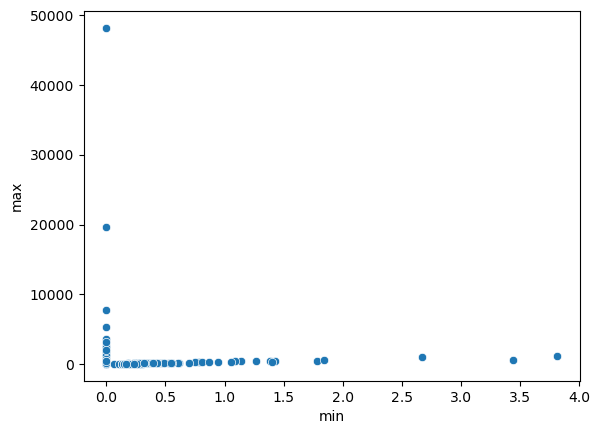

In [10]:
# Print min and max values of every customer in a single plot
# x-axis contains the min values, while y-axis contains the max values.
sns.scatterplot(data=data.describe().T, x=data.describe().T['min'], y=data.describe().T['max'])

Find out the distribution of the data by printing random time series

<AxesSubplot:xlabel='Timestamps'>

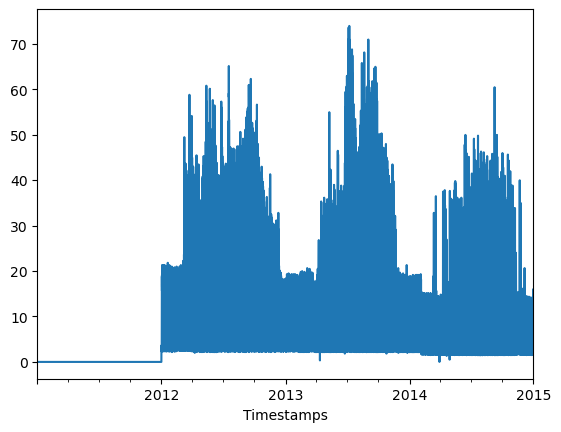

In [11]:
# print time series of customer 'MT_100'
data['MT_100'].plot()

<AxesSubplot:xlabel='Timestamps'>

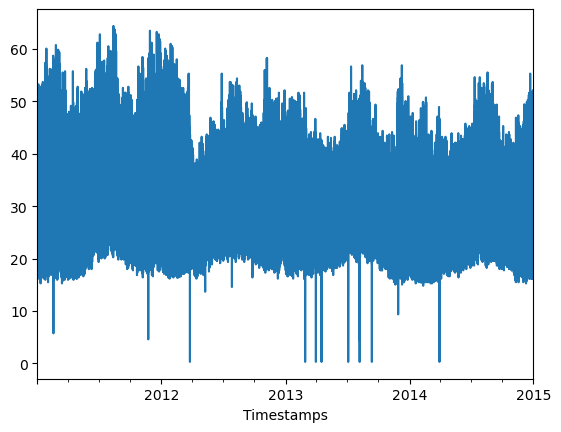

In [12]:
# print time series of customer 'MT_300'
data['MT_300'].plot()

<AxesSubplot:xlabel='Timestamps'>

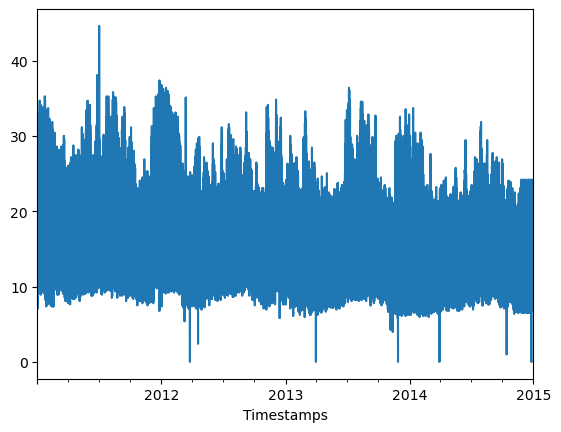

In [13]:
# print time series of customer 'MT_267'
data['MT_267'].plot()

In [14]:
# Aggregate the dataset by hour (use the mean of the observations)
data = data.resample("H").mean()

Begin outlier detection:

In [15]:
# In this dataframe, we will store every value that is an outlier
outliers = pd.DataFrame()

# For each column (client), we will detect outliers using Isolation Forest algorithm
for i in data.columns:
    x = np.array(data[i]).reshape(-1,1)
    model =  IsolationForest(contamination=0.01,random_state=42)
    model.fit(x)
    outliers[i] = model.predict(x)

C:\Users\strat\AppData\Local\Temp\ipykernel_12492\2947572662.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\strat\AppData\Local\Temp\ipykernel_12492\2947572662.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\strat\AppData\Local\Temp\ipykernel_12492\2947572662.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [16]:
# Convert all outliers values (-1) with the mean value of the column
for y in data.columns:
    mean = data[y].mean()
    for i in range(outliers.shape[0]):
        if (outliers[y].iloc[i] == -1):
            data[y].iloc[i] = mean

Visualizations!!!
 
In order to be easier for us, we provide visualizations on the sum of consumpted energy of all clients per time interval (per hour)

In [17]:
# We define some features that might be usefull to our research
data['hour'] = data.index.hour
data['month'] = data.index.month

# Define a new column (the sum of energy consumption in a specific timestamp)
data['Consumption_Sum'] = data.sum(axis=1,numeric_only=True)

<AxesSubplot:xlabel='hour'>

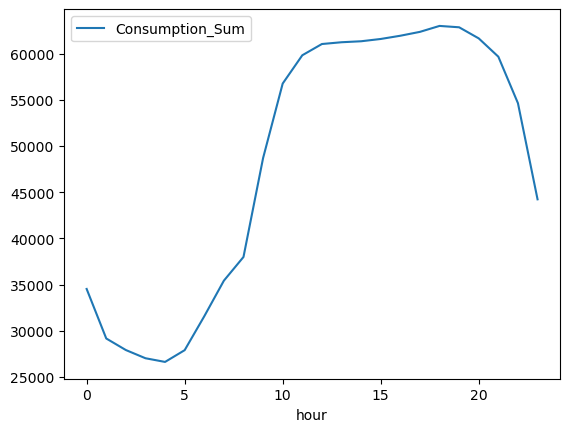

In [18]:
# Plot the sum of energy consumption by hour
data[['Consumption_Sum','hour']].groupby('hour').mean().plot()

<AxesSubplot:xlabel='month'>

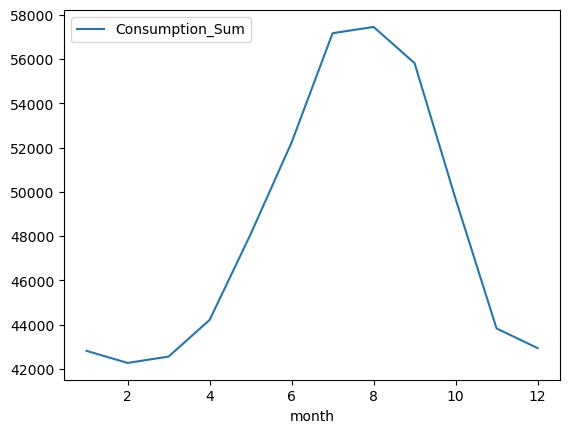

In [19]:
# Plot the sum of energy consumption by month.
data[['Consumption_Sum','month']].groupby('month').mean().plot()

### Step 2: Time Series Clustering

In [20]:
# read and tranform the cleaned data
# do not read columns 'Consumption_Sum','hour','weekday' and 'month'
data.drop("hour", axis=1, inplace=True)
data.drop("month", axis=1, inplace=True)
data.drop("Consumption_Sum", axis=1, inplace=True)
data = data.T
data.head()

Timestamps,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,2011-01-01 03:00:00,2011-01-01 04:00:00,2011-01-01 05:00:00,2011-01-01 06:00:00,2011-01-01 07:00:00,2011-01-01 08:00:00,2011-01-01 09:00:00,...,2014-12-31 15:00:00,2014-12-31 16:00:00,2014-12-31 17:00:00,2014-12-31 18:00:00,2014-12-31 19:00:00,2014-12-31 20:00:00,2014-12-31 21:00:00,2014-12-31 22:00:00,2014-12-31 23:00:00,2015-01-01 00:00:00
MT_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.951777,0.713832,0.475888,0.555203,0.555203,0.555203,0.634518,0.475888,0.555203,0.634518
MT_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.156828,7.201280,7.067923,7.156828,7.067923,6.312233,5.689900,5.512091,5.334282,4.978663
MT_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.380104,0.434405,0.543006,0.651607,0.434405,0.434405,0.434405,0.434405,0.434405,0.434405
MT_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35.060976,38.617886,41.666667,51.702236,52.591463,46.620935,40.523374,40.269309,40.396341,44.715447
MT_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.243902,16.615854,16.996951,21.798780,23.856707,23.018293,21.570122,21.722561,20.960366,21.036585


Reduce dimensions of the original data using PCA method:

In [21]:
# Scale the data using StandardScaler, in order to apply PCA on them
sc = StandardScaler()
data_scaled = sc.fit_transform(data)

In [22]:
# Applying PCA method on the scaled dataset. Reduce to 2 dimensions
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data = data_pca, columns = ['principal component 1', 'principal component 2'])
data_pca.head()

,principal component 1,principal component 2
0,-39.320938,7.317094
1,-37.932677,7.608194
2,-39.439978,7.285885
3,-33.022567,8.973138
4,-36.498708,7.992785


Luckily, the information loss is extremely small

In [23]:
# print the amount of information that PCA holds after dimension reduction
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.74756256 0.19292765]


Start clustering the reduced dimension dataset using K-Means and DBSCAN:

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

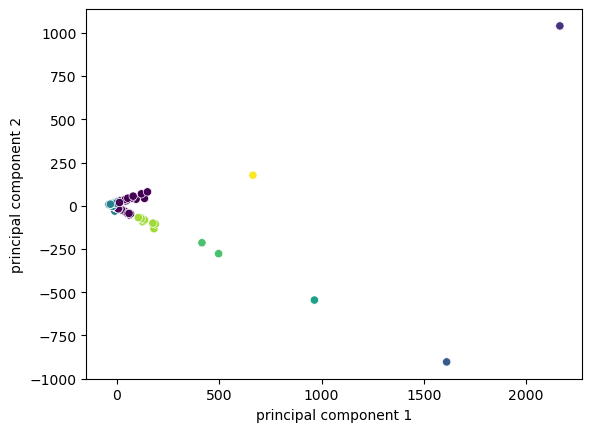

In [24]:
# Cluster the data using 8 clusters and K-Means algorithm
kmeans = KMeans(n_clusters = 8)
labels1 = kmeans.fit_predict(data_pca)

# Plot the clusters after K-Means clustering
sns.scatterplot(x=data_pca['principal component 1'],y=data_pca['principal component 2'],c=labels1)

In [25]:
# Print the cluster in which every customer belongs to
names_for_labels = [f"Cluster {label}" for label in labels1]
clusters = pd.DataFrame(zip(data.T.columns,names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
clusters

,Cluster
Series,
MT_369,Cluster 0
MT_339,Cluster 0
MT_213,Cluster 0
MT_157,Cluster 0
MT_218,Cluster 0
...,...
MT_241,Cluster 6
MT_276,Cluster 6
MT_323,Cluster 6


In [26]:
# Print the number of clients that belong in each cluster
clusters.value_counts()

Cluster  
Cluster 3    316
Cluster 0     39
Cluster 6      9
Cluster 5      2
Cluster 1      1
Cluster 2      1
Cluster 4      1
Cluster 7      1
dtype: int64

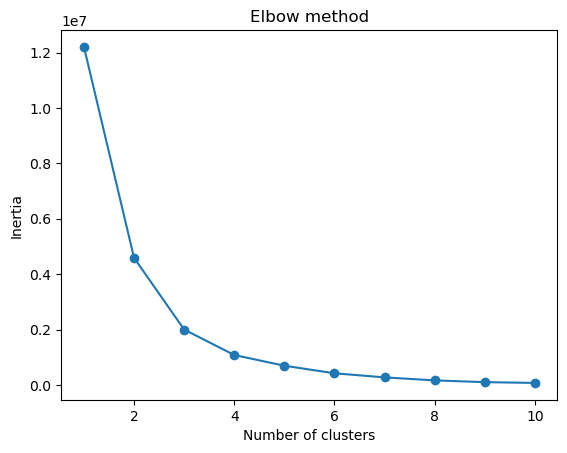

In [27]:
# Set up the elbow method, in order to find best value for K
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

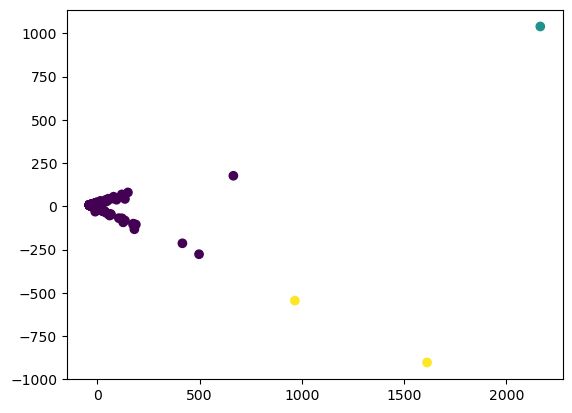

In [28]:
# Best number of clusters, according to Elbow method is K = 3
# So, we apply K-Means using K = 3
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(data_pca)
plt.scatter(data_pca['principal component 1'], data_pca['principal component 2'], c=kmeans.labels_)
plt.show()

In [29]:
# Print the cluster in which every customer belongs to (K=3)
names_for_labels = [f"Cluster {label}" for label in labels]
clusters2 = pd.DataFrame(zip(data.T.columns,names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
clusters2

,Cluster
Series,
MT_001,Cluster 0
MT_251,Cluster 0
MT_250,Cluster 0
MT_249,Cluster 0
MT_248,Cluster 0
...,...
MT_126,Cluster 0
MT_370,Cluster 0
MT_362,Cluster 1


In [30]:
# Print the number of clients that belong in each cluster
clusters2.value_counts()

Cluster  
Cluster 0    367
Cluster 2      2
Cluster 1      1
dtype: int64

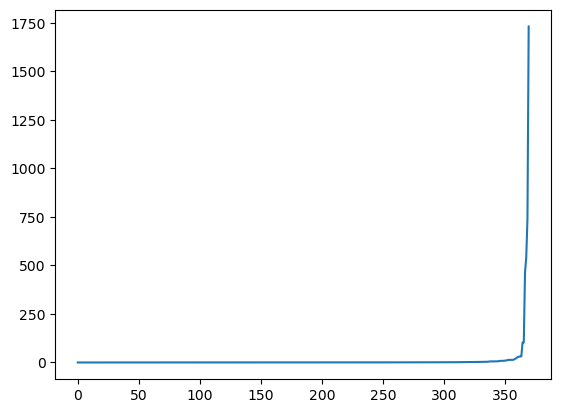

In [31]:
# Find optimum value for e before applying DBSCAN
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(data_pca)
distances, indices = neighbors_fit.kneighbors(data_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Number of values per cluster
  0    352
-1      6
 1      5
 2      4
 3      3
dtype: int64


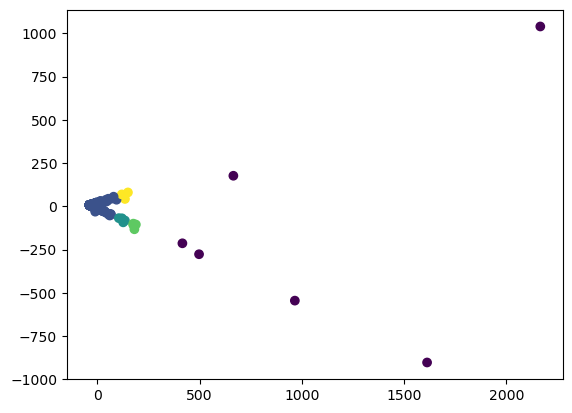

In [32]:
# Based on the plot above, best value for e is e = 40
# Use another algorithm other than K-Means
# In this example, we use DBSCAN
clustering = DBSCAN(eps=40, min_samples=3).fit(data_pca)
clusters3 = clustering.labels_
clusters3 = pd.DataFrame(clusters3)
print("Number of values per cluster\n",clusters3.value_counts())

# Print clusters after DBSCAN algorithm
plt.scatter(data_pca['principal component 1'], data_pca['principal component 2'], c=clustering.labels_)
plt.show()

### Step 3: Build the 2 ML models and evaluate them using MAPE score

Prepare the dataset that we will use for our two ML algorithms (XGboost and Facebook Prophet):

In [33]:
# Select the cluster with the most samples (from DBSCAN's results)
clusters3 = pd.DataFrame(zip(data.T.columns,[f"Cluster {label}" for label in clustering.labels_]),columns=["Client","Cluster"]).sort_values(by="Cluster")
chosen_clients = data.T[clusters3[clusters3["Cluster"] == 'Cluster 0']['Client']].T

Show that clients that belong to the same cluster have almost the same min and max values:

<AxesSubplot:xlabel='min', ylabel='max'>

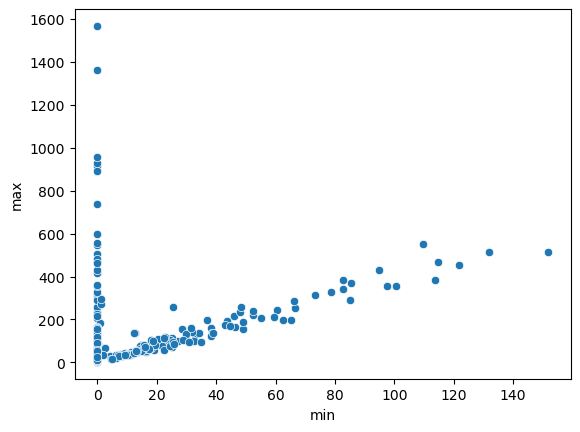

In [38]:
# Print min and max values of every customer in a single plot
# x-axis contains the min values, while y-axis contains the max values.
# We expect that min and max values will be the same among every customer in the dataset.
sns.scatterplot(data=chosen_clients.T.describe().T, x=chosen_clients.T.describe().T['min'], y=chosen_clients.T.describe().T['max'])

Normalize the dataset:

In [39]:
# Normalize the chosen_clients dataframe (Min-Max Normalization)
chosen_clients_scaled = (chosen_clients-chosen_clients.min())/(chosen_clients.max()-chosen_clients.min())

Apply rolling window to increase the amount of data:

In [40]:
# Change The Shape Of DataFrame
chosen_clients_scaled_T = chosen_clients_scaled.T

# Window Rolling Mean (Moving Average)
# Create new time series data based on the average of the existing time series
for name in chosen_clients_scaled_T.columns:
    chosen_clients_scaled_T['2Mean '+name] = chosen_clients_scaled_T[name].rolling(2).mean()


C:\Users\strat\AppData\Local\Temp\ipykernel_12492\1015951694.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\strat\AppData\Local\Temp\ipykernel_12492\1015951694.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\strat\AppData\Local\Temp\ipykernel_12492\1015951694.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [41]:
# Change NaN Values to 0 (NaN values occured due to rolling windows)
chosen_clients_scaled_T = chosen_clients_scaled_T.fillna(0)

In [42]:
# Change The Data Type Of Index Back To Datetime
chosen_clients_scaled_T.index = pd.to_datetime(chosen_clients_scaled_T.index)

In [43]:
# Create 'Consumption_Sum' column
chosen_clients_scaled_T['Consumption_Sum'] = chosen_clients_scaled_T.sum(axis=1)

In [44]:
# This is the final dataset
ModelData = chosen_clients_scaled_T[['Consumption_Sum']]

# Print the final dataset
ModelData.head()

,Consumption_Sum
Timestamps,
2011-01-01 00:00:00,29.606851
2011-01-01 01:00:00,58.296219
2011-01-01 02:00:00,59.041983
2011-01-01 03:00:00,59.266659
2011-01-01 04:00:00,60.044196


Train/Test split of the final dataset

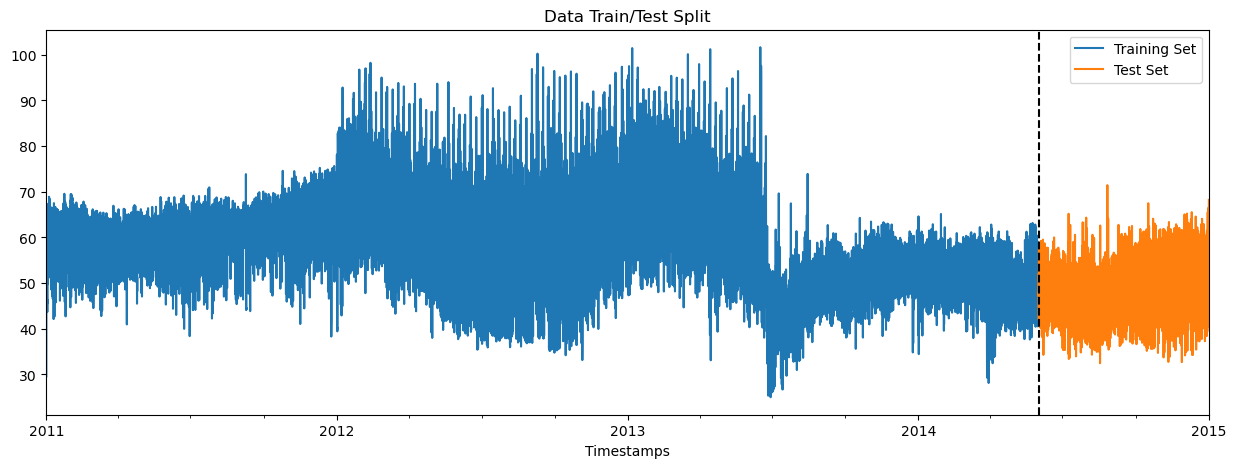

In [45]:
# Split the data into train, validation and test set
train = ModelData.loc[ModelData.index < '2014-06-01']
test = ModelData.loc[ModelData.index >= '2014-06-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2014-06-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [46]:
# We define some features that might be usefull to our research
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['year'] = df.index.year
    
    return df

ModelData = create_features(ModelData)

Define Features and Labels

In [47]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'year','hour','day']
TARGET = 'Consumption_Sum'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

Create First Model (XGBoost)

In [48]:
# We use a regressor as our first model
reg = xgb.XGBRegressor(n_estimators=10000,
                       early_stopping_rounds=20,
                       objective='reg:squarederror',
                       learning_rate=0.01)

# Train the first model (use of validation set)
reg.fit(X_train, y_train,eval_set=[(X_train, y_train)],verbose=100)

[0]	validation_0-rmse:57.82689
[100]	validation_0-rmse:21.76530
[200]	validation_0-rmse:9.20590
[300]	validation_0-rmse:5.54102
[400]	validation_0-rmse:4.73155
[500]	validation_0-rmse:4.53426
[600]	validation_0-rmse:4.45197
[700]	validation_0-rmse:4.39387
[800]	validation_0-rmse:4.34142
[900]	validation_0-rmse:4.29379
[1000]	validation_0-rmse:4.24722
[1100]	validation_0-rmse:4.20670
[1200]	validation_0-rmse:4.17062
[1300]	validation_0-rmse:4.13068
[1400]	validation_0-rmse:4.09921
[1500]	validation_0-rmse:4.07231
[1600]	validation_0-rmse:4.04920
[1700]	validation_0-rmse:4.02797
[1800]	validation_0-rmse:4.00132
[1900]	validation_0-rmse:3.97235
[2000]	validation_0-rmse:3.94888
[2100]	validation_0-rmse:3.92755
[2200]	validation_0-rmse:3.89969
[2300]	validation_0-rmse:3.87982
[2400]	validation_0-rmse:3.86451
[2500]	validation_0-rmse:3.84521
[2600]	validation_0-rmse:3.82349
[2700]	validation_0-rmse:3.79442
[2800]	validation_0-rmse:3.76868
[2900]	validation_0-rmse:3.75280
[3000]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=20, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Forecast on test set (First Model)

In [49]:
# predict on test set
predictions_XGboost = reg.predict(X_test)

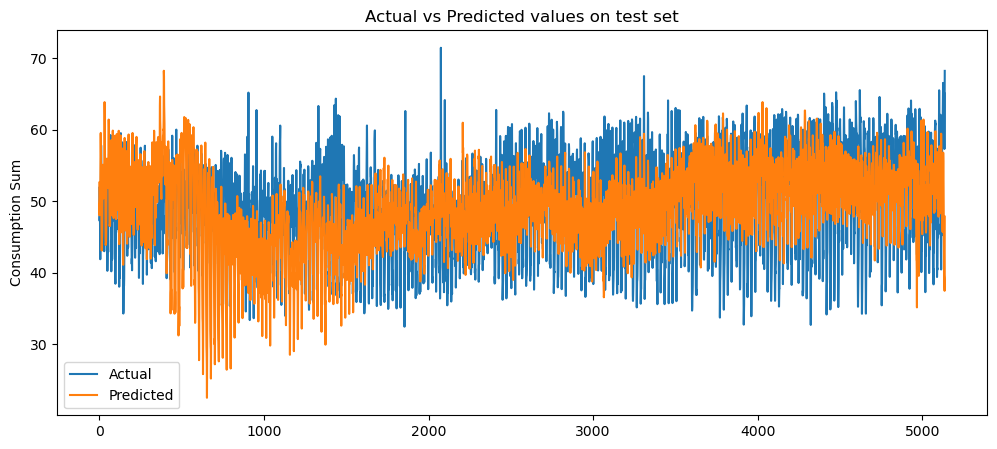

In [50]:
# Plotting graph for test and predicted values
plt.figure(figsize=(12,5))
plt.plot(list(y_test))
plt.plot(list(predictions_XGboost))
plt.title("Actual vs Predicted values on test set")
plt.ylabel("Consumption Sum")
plt.legend(('Actual','Predicted'))
plt.show()

Estimate Score of first ML model

In [51]:
MAPE_XGboost = mean_absolute_percentage_error(y_test, predictions_XGboost)
print("The mean of all absolute percentage errors between the predicted and actual values is (%): ",MAPE_XGboost)

The mean of all absolute percentage errors between the predicted and actual values is (%):  0.11888439483459955


Now it is time to start future prediction with XGboost (short term and future term)

In [52]:
# Make a new dataframe, in which future predictions will be stored
future_dates = pd.date_range(start='2015-01-01 01:00:00',freq='H',periods=71)
df_future_dates = pd.DataFrame(future_dates,columns=['Timestamps'])
df_future_dates['Consumption_Sum'] = np.nan
df_future_dates.index = pd.to_datetime(df_future_dates['Timestamps'], format= '%Y-%m-%d %H:%M:%S')
df_future_dates.drop("Timestamps",axis=1,inplace=True)
df_future_dates = create_features(df_future_dates)
df_future_dates.head()

,Consumption_Sum,month,day,hour,year
Timestamps,,,,,
2015-01-01 01:00:00,NaN,1,1,1,2015
2015-01-01 02:00:00,NaN,1,1,2,2015
2015-01-01 03:00:00,NaN,1,1,3,2015
2015-01-01 04:00:00,NaN,1,1,4,2015
2015-01-01 05:00:00,NaN,1,1,5,2015


In [53]:
# Predict the future consumption sum (short and long term) using XGboost
X_test_future = df_future_dates[FEATURES]
y_test_future = df_future_dates[TARGET]
predicted_future_results = reg.predict(X_test_future)
df_future_dates['Consumption_Sum'] = predicted_future_results

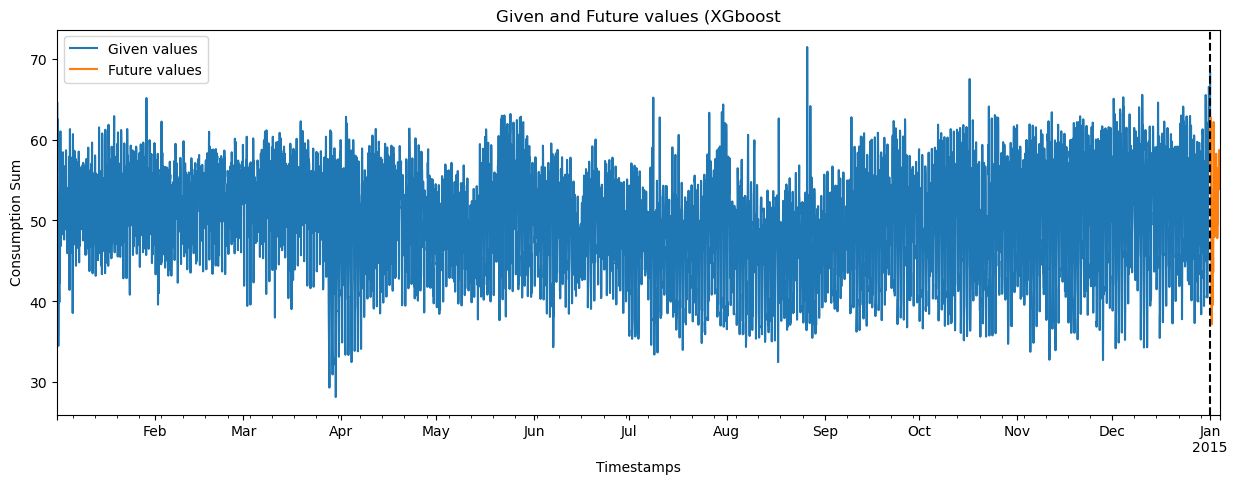

In [54]:
# Plot given and future consumptions alongside in the same graph
concat = pd.concat([ModelData,df_future_dates])
given = concat['Consumption_Sum'].loc[(concat.index <= '2015-01-01') & (concat['Consumption_Sum'].index > '2014-01-01')]
future = concat['Consumption_Sum'].loc[concat.index > '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
given.plot(ax=ax, label='GivenData', title='Given and Future values (XGboost')
future.plot(ax=ax, label='Future calues')
plt.ylabel("Consumption Sum")
ax.axvline('2015-01-01', color='black', ls='--')
ax.legend(['Given values', 'Future values'])
plt.show()

Create Second Model (Prophet)

In [55]:
# Prophet need out DataFrame to have specific column names, in order to be functional
ModelData_2 = ModelData['Consumption_Sum'].reset_index()

# Rename Columns
ModelData_2 = ModelData_2.rename(columns={'Timestamps': 'ds','Consumption_Sum': 'y'})

# Print final dataset (modified)
ModelData_2.head()

,ds,y
0,2011-01-01 00:00:00,29.606851
1,2011-01-01 01:00:00,58.296219
2,2011-01-01 02:00:00,59.041983
3,2011-01-01 03:00:00,59.266659
4,2011-01-01 04:00:00,60.044196


In [56]:
# Create the second model
prophet_model = Prophet(interval_width=0.95)

Train the second ML model:

In [57]:
# Train the second model
prophet_model.fit(ModelData_2)

16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing


Make predictions (Prophet model):

In [58]:
# Create future dates (up to 3 days next) for which we want predictions
future_dates = prophet_model.make_future_dataframe(periods=71,freq='H')
future_dates.head()

,ds
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00


yhat column contains the predicted  values that the model gave us

In [59]:
# make predictions using Prophet model
forecast = prophet_model.predict(future_dates)
forecast[['ds', 'yhat']].tail()

,ds,yhat
35131,2015-01-03 19:00:00,52.282362
35132,2015-01-03 20:00:00,53.762100
35133,2015-01-03 21:00:00,54.469645
35134,2015-01-03 22:00:00,53.765863
35135,2015-01-03 23:00:00,51.940444


Print MAPE score of prophet ML model:

In [60]:
MAPE_prophet = mean_absolute_percentage_error(ModelData_2['y'], forecast['yhat'].head(35065))
print("The mean of all absolute percentage errors between the predicted and actual values is (%): ",MAPE_prophet)

The mean of all absolute percentage errors between the predicted and actual values is (%):  0.10492044761595487


### Step 4: Generate report

<AxesSubplot:xlabel='hour'>

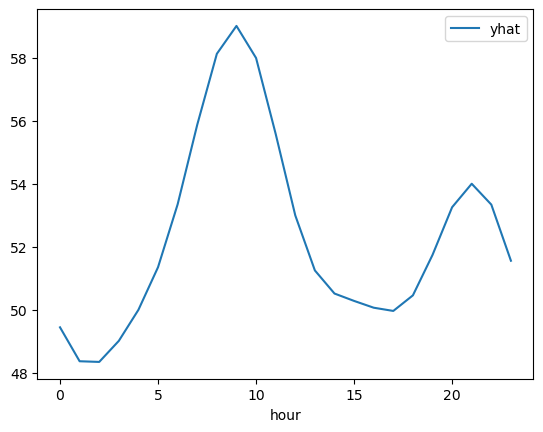

In [61]:
# Plot future consumption sum per hour
future = forecast[['ds', 'yhat']].tail(72)
future.index = pd.to_datetime(future['ds'], format= '%Y-%m-%d %H:%M:%S')
future['hour'] = future.index.hour
future[['yhat','hour']].groupby('hour').mean().plot()